# Aula 6 - BigData Algorithms
---

## TODAY

- DataStreaming - Filtering DataStreaming  - **Bloom Filtering**

- Window Counting - **DGIM Method**
- Counting Distinct Occorrences - **Flajolet-Martin** or **HyperLogLog**

# Data Streamming (realtime data)

This is a common situation in BigData that is not comparable with a normal data Scenario:

**Data Streaming appears when we can think of the data as infinite and non-stationary (the distribution changes over time)**

e.g. Google queries, Twitter or Facebook status updates

### Characteristics:

- The system cannot store the entire stream
- Streams often deliver elements very rapidly. 
- We must process elements in real time, or we lose the opportunity to process them at all (forced to be main memory calculations)
- ** Approximate solutions are often acceptable**



### Kind of problems 

- Queries over sliding windows
- Filtering a data stream
- Select elements with property x from the stream
- Counting distinct elements
- Number of distinct elements in the last k elements of the stream
- Estimating moments (average, Standard Deviation, etc.)
- Finding frequent elements
...



## Let's see 2 Examples

### 1) Fixed Size Random Sampling (with substitution of new values over old values)

Imagine you have a list of user queries with the following fields: 

Queries(UserID, QueryID, TimeStamp)

Consider the following question: ***in the set of user queries, how many queries were used twice by the same user***? 

and consider you cannot keep all data: you have to random sampling your data.

(hash functions are used for speed!)



Consider we have a d = 1000 (doubled queries) and x = 5000 (unique queries). So, a total of 7000 queries and 6000 unique queries (d+x).

The right answer would be $1000/6000 = 16\%$ (1000 queries of 6000 unique queries)

Let us now random sample and see the results:

In [219]:
#generating data
import math, random
queries = np.random.choice(range(200000), 6000, replace=False)

#create queryID, userID, TimeStamp
queries = np.concatenate([queries, np.random.choice(queries,1000, replace=False)]).reshape(-1,1)
np.random.shuffle(queries)
queries

array([[ 10366],
       [110318],
       [  2012],
       ..., 
       [ 16337],
       [ 90959],
       [ 20869]])

In [223]:
#Add userId
users = np.random.choice(range(200), 7000, replace=True).reshape(-1,1)

#Add TimeStamp

timestamp = np.array(range(1508513453,1515513453,1000)).reshape(-1,1)

print(queries.shape, users.shape, timestamp.shape)
data = np.concatenate([queries, users, timestamp], axis=1)
#generating data OVER

print(data)

#Select 1/10 using an hash function:
sub_queries = np.array([q for q in data if math.floor(random.random()*10)==1])
print(sub_queries.shape)

(7000, 1) (7000, 1) (7000, 1)
[[     10366        119 1508513453]
 [    110318        126 1508514453]
 [      2012         53 1508515453]
 ..., 
 [     16337        174 1515510453]
 [     90959        189 1515511453]
 [     20869         35 1515512453]]
(679, 3)


With this technique do we have 1/10 of the data for sure? No, we have a noisy approximation of that quantity.

In [242]:
sub_queries.sort()
X = np.diff(sub_queries[:,0])

S = np.append((X==0), False)
S


print("sample percentage")
print(sub_queries.shape[1]/queries.shape[0]*100, "%")
print("-----")
print("Percentage of duplicates (should be 16%)")
#print(sub_queries[S.tolist(),0].shape[0]/sub_queries.shape[0])
print(sub_queries[S.tolist()].shape[0]/sub_queries.shape[0]*100, "%")

sample percentage
0.04285714285714286 %
-----
Percentage of duplicates (should be 16%)
0.14727540500736377 %


Aprox. 10 times less.... why? Because we loose the duplicated proportion information. For aleatory values it can be shown that 

$$ Duplicates = d/(10s+19d)$$

for 0.1 times sample. In this case, 1000/(60000+19000) = 1,2% (aprox 10% of the real value 16%) 

#### Conclusion:

For many statistical queries, sampling destroys data is not well thought. In this case, we should consider other kind of information: for instance, the user: It's preferable to keep a complete query history of less users to have a good estimate of duplicated queries.

**In that case, the hashing function should be done over the userID instead of the queryID**


This allows to have related queries in the sample, and avoid relevant missing duplicates

### 2) Filtering a Data Stream based on a given Set

#### Section 1) made us have a second problem: Filtering a data stream based on a given Set of keys.

If the selection criterion is a property of the regiter that can be calculated (e.g., an attribute is less than 10), then the selection is easy to do. 

**The problem becomes harder when the criterion involves lookup for membership in a set (specially when it does not fit in main memory).**


----

#### Example: Email Filtering based on "from" field using ***one gigabyte memory***:

We have a list of 1E9 email names that are acceptable (if the email has 20 bytes, 20TB of space are needed).

Disk Access? or ...(first Attempt) apply an hash function in this way:


> - Given a set of keys **S** **(valid emails)** that we want to filter
> - Create a bit array **B** of **n bits** (1GB means 8E9 bits), initially all 0s
> - Choose a hash function h with range **[0,n)**
> - Hash each member of s ∈ S to one of n buckets, and set that bit to 1, i.e., B[h(s)]=1   

You have now the filter Ready. Let's Start Sending emails to the filter:

> - For each new email **a** in the stream, Hash it as h(a)
> - **Output a if B[h(a)] == 1**

#### Let's Analyze sizes:

- Number of known emails:

> |S| = 1E9 emails

- Number of bits in the filter:

> |B| = 8 Gbits (Feasible)

- Number of bits setted to 1 in the filter:

> (1/8 of the bits are set to 1 if each email assigns a bit to one - actually the value is slightly less)

- If the email address is in S, then it surely hashes to a bucket set to 1, so it always gets through **(no false negatives)**


- If stream emails are equally spanned by all buckets using $h(a)$, about 1/8th of the addresses not in S get through to the output generating **false positives** (span emails that pass through)




However, there are a better implementation for big data: Bloom Filter.

---

# BLOOM FILTERS

## Question: Filtering a data stream by elements existing in other set

---




## 1st Method: Hash table Method
This is the "obvious solution" 



> - Given a set of keys **S** **(valid emails)** that we want to filter
> - Create a bit array **B** of **n bits** (1GB means 8E9 bits), initially all 0s
> - Choose a hash function $h$ with range **[0,n)**
> - Hash each member of s ∈ S to one of n buckets, and set that bit to 1, i.e., B[h(s)]=1   

You have now the filter Ready. Let's Start Sending emails to the filter:

> - For each new email **a** in the stream, Hash it as h(a)
> - **Output a if B[h(a)] == 1**


<img src="images/hash_filter.png" style="width:60%"/>


### Hash Table Results

**It creates false positives but no false negatives**

- |S| = 1 billion email addresses 
- |B|= 1GB = 8 billion bits

If the email address is in S, then it surely hashes to a bucket that has the big set to 1, so it always gets through (no false negatives)

**Approximately 1/8 of the bits are set to 1, so about 1/8th of the addresses not in S get through to the output (false positives)**

Actually, less than 1/8th, because more than one address might hash to the same bit.

---

## 2nd Method: Bloom Filter

**Method Description: **

- Use $k$ independent hash functions $h_1 ,..., h_k$
- $|S| = m$ (Valid email addresses)
- $|B| = n$ (Hash Filter array)


- INITIALIZE
    - Set $B$ to all $0s$
    - Hash each element $s∈S$ using each hash function hi, set $B[h_i(s)]=1$ (for each $i=1,..,k$)

> Remember: There is just 1 B array!


- RUNTIME
    - When a stream element with key $x$ (new email!) arrives, If $B[h_i(x)]=1$ **for all i=1,...,k** - That is, if $x$ hashes to a bucket set to $1$ for every hash function $h_i(x)$ - then declare that $x$ is in $S$ 
    - Otherwise discard the element x
---

<img src="images/bloom_filter.png" style="width:40%"/>

----


#### Bloom Filter False Positive Analisys

m= 1 US billion (S)
n= 8 US billion (B)

- k=1: (Hash function): 0.1175 (about 1/8th)
- k=2: 0.0493
- k=6: 0.0235 (Optimum)

**Only 2% false positive instead of ~12% (Hash function)**

#### Bloom Filter Wrap-up

- No false negatives
- Great for pre-processing before more expensive checks
- **Only 2% false positive instead of ~12% (Hash function)**

---

----


# DGIM METHOD

## Counting bits in a Window 

---

### Question: How many 1s are in the last k bits? where k ≤ N
---

- Fixed-size sample or Reservoir Sampling or Sliding window

Obvious solution:
Store the most recent N bits
When new bit comes in, discard the N+1st bit

<img src="images/1stsol.png" style="width:50%"/>

### Real problem

What if we cannot afford to store N bits?
E.g., we’re processing 1 billion streams and
N = 1 billion
> You can not get an exact answer without storing the entire window

---

#### 1 solution: Uniformity assumption

<img src="images/unif_assumption.png" style="width:50%"/>

Maintain 2 counters:
- S: number of 1s from the beginning of the stream 
- Z: number of 0s from the beginning of the stream

How many 1s are in the last N bits? This could be found by.

$$N\frac{S}{s+Z}$$


#### Lacking Uniformity Assumption

---

#### 2 solution: Solution that doesn’t (quite) work

- Summarize exponentially increasing regions of the stream, looking backward
- Drop small regions if they begin at the same point as a larger region



<img src="images/2nd_sol.png" style="width:70%"/>


- We can reconstruct the count of the last N bits, except we are not sure how many of the last 6 1s are included in the N

#### GOOD THINKS vs BAD THINGS:

- Error in count no greater than the number of 1s in the “unknown” area
- But it could be that all the 1s are in the unknown area at the end - in that case, the error is unbounded!

## DGIM Method [Datar, Gionis, Indyk, Motwani]

Instead of summarizing fixed-length blocks, summarize blocks with specific number of 1s - **Let the block sizes (and so, the number of 1s in each block) increase exponentially**

- Either one or two blocks with the same power-of-2 number of 1s
- Buckets do not overlap in timestamps   
- Buckets are sorted by size
- Earlier blocks are not smaller than later blocks   
- Buckets disappear when their end-time is > N time units in the past


<img src="images/DGIM.png" style="width:70%"/>

---

#### What is saved

- (A) The timestamp of its end ```[O(log N) bits]```
- (B) The number of 1s between its beginning and end ```[O(log log N) bits]```

> Why the timestamp uses O(log N) bits: each timestamp is at most at position N. This position is stored with O(log N) bits (MAX) - so, we need ```[O(log N)]``` bits to keep all timestamps.

> Why O(log log N) bits: With quantity of 1s = N,  since the number of 1s grows with power of 2, we can keep all blocks with ```log N``` bits. But for each bucket we need ```log N``` bits to keep the quantity - so we need ```O[log(log(N))]``` bits in total to keep qantities.

---

#### What happens when a new value come in?

Two possibilies:

- If the current bit is 0: no other changes are needed

- If the current bit is 1:
    - (1) Create a new bucket of size 1, for just this bit
> End timestamp = current time
    - (2) If there are now three blocks of size 1, combine the oldest two into a bucket of size 2
    - (3) If there are now three blocks of size 2, combine the oldest two into a bucket of size 4
    - (4) And so on...



<img src="images/DGIM2.png" style="width:70%"/>


---

#### How to estimate the number of 1s

To estimate the number of 1s in the most recent k<N bits:

- Sum the sizes of all blocks but the last - size means the number of 1s.
- Add just half the size of the last bucket

> Why half the size: because we do not know how many 1s of the last bucket are still within the wanted window, our best guess is half the quantity.

#### Resulting error: < 50%

The error worst case scenario is when all data in the last bucket is wronlgy counted. That means 50% of the last bucket was considered to be 1s and it was 0's. Since the quantity of 1s in the last bucket is (in the worst case) 50% of the existent 1s in the last k bits, our error is at most 50%.


#### Not enough? Add more blocks per power-of-two value

We can improve this result by increasing the number of blocks (r) per power-of-two. This means we have, for instance, r=4


```
    ....16-16-16-16-8-8-8-8-4-4-4-4-2-2-2-2-1-1-1-1
``` 


**In this case, the error is O(1/r)**

By picking r appropriately, we can tradeoff **between number of bits we store** and the **error bound**


## OTHER USAGES FOR DGIM METHOD

Can we handle the case where the stream is not bits, but integers, and we want the sum
of the last k elements? Yes.

Why should we? **For instance, we want to calculate the Avg. price of last k sales.**

### If you know all have at most m bits:

- Treat each bit of the m bits of each integer as a separate stream
- Use DGIM to count 1s in each integer ($c_i$)
- We can calculate the total sum using
    
$$\sum_{i=0}^{m-1}c_i2^i$$



# FLAJOLET-MARTIN METHOD 
## Counting Distinct Occorrences 
----

#### Usage:

- How many different Web pages does each customer request in a week?
- How many distinct products have we sold in the last week?

#### Characteristics


- Data stream consists of a universe of elements chosen from a set of size N
- Maintain a count of the number of distinct elements seen so far


#### Obvious Approach 

**keep an hash with the set of elements seen so far**

#### What if we do not have space to maintain the set of elements seen so far?

and we want to...

- Estimate the count in an unbiased way
- Accept that the count may have a little error, but limit the probability that the error is large


### FLAJOLET-MARTIN METHOD 

- Pick a hash function h that **maps randomly** each of the N elements to at least $log_2N$ bits ( binary representation for instance!) 
- For each stream element ```a```, let r(a) be the number of trailing 0s in h(a).

> say h(a) = 12, then 12 is 1100 in binary, so r(a) = 2
    
    
- Record R = the maximum r(a) seen
- In That Case, **the estimated number of distinct elements is equal to $2^R$**

(WHAT???)

#### How it works empirically:

- $h(a)$ is a sequence of $log_2 N$ bits


- What fraction of all "a" values have a tail of r zeros:
> - About 50% of as hash to ***0
> - About 25% of as hash to **00
> - About 12,5% of as hash to *000


That means 

- $2^{-r}$ fraction of all "a" values have a tail of r zeros:

**So, if we saw the longest tail of r=2 (i.e., item hash ending *100) then we have probably seen about 4 distinct items so far**

This means that, on average, it takes to hash about $2^r$ items before we see one with zero-suffix of length r;


#### How it works formally:

- What is the probability that a given h(a) ends in at least r zeros is $2^{-r}$?
- h(a) hashes elements uniformly at random   
- Probability that a random number ends in at least r zeros is $2^{-r}$

Then, the probability of NOT seeing a tail of length r among m elements is


<img src="images/FLAJOLET-MARTIN.png" style="width:40%"/>

Note that 

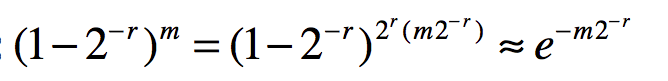

- if m >> $2^r$, then prob. tends to 0
- if m << $2^r$, then prob. tends to 1

> This means that $2^r$ will almost always be around m

